<a href="https://colab.research.google.com/github/CadeHarger/portfolio/blob/main/Personal_Projects/Naive_Image_Generation_from_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [ ]:
#@title Import Relevant Modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import time
import math
import random

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [ ]:
#@title Load the Dataset
(featureSet, labelSet),(testFeaturesSet, testLabelSet) = tf.keras.datasets.cifar10.load_data()
featureSetNorm = featureSet / 255
testFeatureSetNorm = testFeaturesSet / 255
print(featureSetNorm.shape)
print(testFeatureSetNorm.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [ ]:
#@title Add Noise to Dataset
noisePics = np.zeros((7000, 32, 32, 3), dtype=np.float32)
for data in range(len(noisePics)):
   noisePics[data] = np.random.rand(32, 32, 3)
noiseLabels = np.zeros((len(noisePics), 1), dtype=np.int8) + 10

featureSetNorm = np.append(featureSetNorm, noisePics[0:5000], axis=0)
testFeatureSetNorm = np.append(testFeatureSetNorm, noisePics[5000:], axis=0)
labelSet = np.append(labelSet, noiseLabels[0:5000], axis=0)
testLabelSet = np.append(testLabelSet, noiseLabels[5000:], axis=0)

print(featureSetNorm.shape)
print(testFeatureSetNorm.shape)
print(labelSet.shape)
print(testLabelSet.shape)

shuffler = np.random.permutation(len(featureSetNorm))
featureSetNorm = featureSetNorm[shuffler]
labelSet = labelSet[shuffler]

shuffler = np.random.permutation(len(testFeatureSetNorm))
testFeatureSetNorm = testFeatureSetNorm[shuffler]
testLabelSet = testLabelSet[shuffler]

(55000, 32, 32, 3)
(12000, 32, 32, 3)
(55000, 1)
(12000, 1)


TypeError: ignored

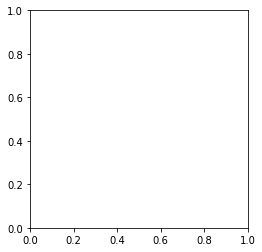

In [ ]:
#@title Transform Features and Labels to (Edge Detection : Picture)

edgeDist = 0.25

def colorDist(pix1, pix2):
  redDist = pix2[0] - pix1[0]
  blueDist = pix2[1] - pix1[1]
  greenDist = pix2[2] - pix1[2]
  return math.sqrt(redDist * redDist + blueDist * blueDist + greenDist * greenDist)
'''
#first turn pictures black and white
black = np.zeros((len(featureSetNorm), len(featureSetNorm[0]), len(featureSetNorm[0][0]), 1), dtype=np.float32)
for data in range(len(featureSetNorm)):
  for x in range(len(featureSetNorm[0])):
    for y in range(len(featureSetNorm[0][0])):
      black[data][x][y][0] = np.average(featureSetNorm[data][x][y])
testBlack = np.zeros((len(testFeatureSetNorm)), (len(testFeatureSetNorm[0]), len(testFeatureSetNorm[0][0]), 1), dtype=np.float32)
for data in range(len(testFeatureSetNorm)):
  for x in range(len(testFeatureSetNorm[0])):
    for y in range(len(testFeatureSetNorm[0][0])):
      testblack[data][x][y][0] = np.average(testFeatureSetNorm[data][x][y])
'''
#transform the features to edge detection
edges = np.zeros((len(featureSetNorm), len(featureSetNorm[0]), len(featureSetNorm[0][0]), 1), dtype=np.int8)
for data in range(len(featureSetNorm)):
  for x in range(len(featureSetNorm[0]) - 1):
    for y in range(len(black[0][0]) - 1):
      edges[data][x][y] = 1 * (colorDist(featureSetNorm[data][x][y], featureSetNorm[data][x+1][y]) > edgeDist) or (colorDist(featureSetNorm[data][x][y], featureSetNorm[data][x][y+1]) > edgeDist)



In [ ]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [ ]:
#@title Setup Machine Learning
def createModel(lr):

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Dropout(rate=0.2))

  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Dropout(rate=0.3))

  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))

  model.add(tf.keras.layers.MaxPooling2D((2, 2)))
  model.add(tf.keras.layers.Dropout(rate=0.4))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_uniform'))

  # Define a dropout regularization layer.
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=11, activation='softmax'))

  opt = tf.keras.optimizers.Adam(lr=lr)
  #tf.keras.optimizers.Adam(lr=lr)
  model.compile(optimizer= opt,
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

  return model

def trainModel(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split=validation_split)

  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch.
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist

test = createModel(0.001)
test.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

Epoch 1/150
20/20 [==============================] - 39s 173ms/step - loss: 2.6004 - accuracy: 0.1064 - val_loss: 2.1930 - val_accuracy: 0.1586
Epoch 2/150
20/20 [==============================] - 3s 147ms/step - loss: 2.1700 - accuracy: 0.1749 - val_loss: 1.9917 - val_accuracy: 0.2503
Epoch 3/150
20/20 [==============================] - 3s 148ms/step - loss: 1.9857 - accuracy: 0.2454 - val_loss: 1.8552 - val_accuracy: 0.3000
Epoch 4/150
20/20 [==============================] - 3s 148ms/step - loss: 1.8635 - accuracy: 0.2947 - val_loss: 1.7105 - val_accuracy: 0.3672
Epoch 5/150
20/20 [==============================] - 3s 147ms/step - loss: 1.7622 - accuracy: 0.3452 - val_loss: 1.6336 - val_accuracy: 0.4033
Epoch 6/150
20/20 [==============================] - 3s 149ms/step - loss: 1.6523 - accuracy: 0.3854 - val_loss: 1.5260 - val_accuracy: 0.4405
Epoch 7/150
20/20 [==============================] - 3s 149ms/step - loss: 1.5663 - accuracy: 0.4160 - val_loss: 1.4557 - val_accuracy: 0.469

[0.599276065826416, 0.830299973487854]

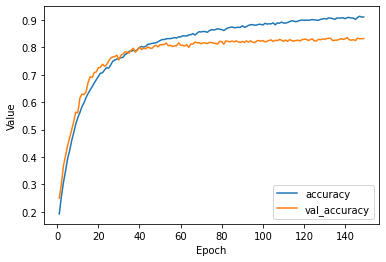

In [ ]:
#@title Training
learning_rate = 0.003
epochs = 150
batch_size = 2000
validation_split = 0.2

# Establish the model's topography.
model = createModel(learning_rate)

# Train the model on the normalized training set.
epochs, hist = trainModel(model, featureSetNorm, labelSet,
                           epochs, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy', 'val_accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
model.evaluate(x=testFeatureSetNorm, y=testLabelSet, batch_size=batch_size)

In [ ]:
#@title Image Recreation
blank = np.zeros((1,32,32,3), dtype=np.float32)
accuracy = 0.0
#probabilityMatrix = np.zeros((28,28), dtype=np.float32) + 0.9
#modifiedMatrix = np.zeros((28,28), dtype=np.bool_)

while accuracy < 0.99995:
  prevBlank = blank.copy()
  scale = (math.sqrt(1 - accuracy))
  for x in range(len(blank[0])):
    for y in range(len(blank[0][0])):
      if random.random() < 0.5:
        #modifiedMatrix[x][y] = True
        if random.random() > 0.5:
          blank[0][x][y][0] += random.random() * scale
          blank[0][x][y][1] += random.random() * scale
          blank[0][x][y][2] += random.random() * scale
        else:
          blank[0][x][y][0] += random.random() * -1 * scale
          blank[0][x][y][1] += random.random() * -1 * scale
          blank[0][x][y][2] += random.random() * -1 * scale
        for z in range(3):
          if blank[0][x][y][z] < 0:
            blank[0][x][y][z] = 0
          elif blank[0][x][y][z] > 1:
            blank[0][x][y][z] = 1
  prevAccuracy = accuracy
  accuracy = np.sum(model.predict(blank)[0][0:10])
  print(accuracy)
  if accuracy < prevAccuracy:
    blank = prevBlank.copy()
    accuracy = prevAccuracy
    #modifiedMatrix = np.zeros((28,28), dtype=np.bool_)
  else:
    print("")
    blank = (blank - np.min(blank))/(np.max(blank) - np.min(blank))

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

0.0

1.7870236e-37

1.8543911e-35

0.0
0.0
0.0
6.3033355e-30

2.345317e-38
0.0
7.4218195e-24

7.342062e-12

1.6833626e-32
2.9935583e-30
1.1816581e-23
1.0691321e-20
0.0
2.2639981e-35
2.296355e-29
4.502393e-29
5.841483e-28
2.7145482e-27
3.4451285e-23
1.1385038e-31
2.019008e-12
1.6157737e-35
3.8113938e-27
9.254905e-27
3.1256915e-26
5.0031695e-33
5.8197e-14
7.943441e-36
3.8098393e-31
3.0265625e-24
5.1157568e-27
1.1027608e-31
8.638927e-30
1.3421611e-22
4.6177387e-28
0.0
5.9354662e-33
2.0037237e-25
8.415112e-25
5.1864997e-27
3.5493814e-27
2.3900832e-18
1.3883464e-20
6.1026063e-24
1.7637504e-29
4.646222e-25
5.572257e-22
1.132683e-16
1.8702672e-34
3.680737e-26
3.2079702e-28
1.08620014e-26
5.7301784e-19
3.390058e-30
3.4056507e-23
4.3047015e-25
4.352608e-29
2.0072789e-31
2.0984468e-29
2.1372907e-27
1.1225859e-33
2.32423e-22
1.6346741e-13
1.7833112e-38
4.077938e-26
7.59244e-10

1.2294557e-27
4.4287606e-33
1.7096436e-16
1.5079443e-19
6.088793e-24
1

KeyboardInterrupt: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.5864587 0.0


array([[2.6028839e-21, 2.6049342e-18, 1.0031580e-11, 6.0301775e-10, 1.9244036e-10, 1.0333617e-16, 1.0000000e+00, 7.0317824e-21, 8.9560757e-17, 1.2217525e-16]], dtype=float32)

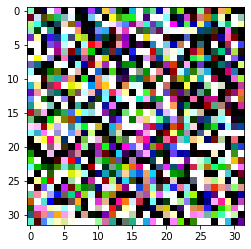

In [ ]:
#@title Display Image
print(np.max(blank), np.min(blank))
plt.imshow(blank.reshape((32,32,3)))
model.predict(blank)

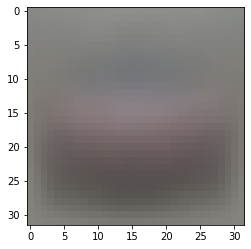

In [ ]:
#@title Display Average
'''
0 - airplane
1 - automobile
2 - bird
3 - cat
4 - deer
5 - dog
6 - frog
7 - horse
8 - ship
9 - truck
'''
count = 0
average = np.zeros((32, 32, 3), dtype=np.float32)
for data in range(len(featureSetNorm)):
  if labelSet[data] == 3:
    count += 1
    average = np.add(average, featureSetNorm[data])
average = average / count
plt.imshow(average)